In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
cd /content/gdrive/MyDrive/Masterarbeit/medmnist

/content/gdrive/MyDrive/Masterarbeit/medmnist


In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=0abd887cdc0dd608764e2a1f3ff1771db223c22630b8a26943795afa85292950
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import medmnist
from medmnist import INFO, Evaluator
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])
print(info["task"])

binary-class


In [ ]:
import torchvision.transforms as transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_dataset = DataClass(split='train',transform = data_transform, download=True)
val_dataset = DataClass(split='val', transform = data_transform, download=True)
test_dataset = DataClass(split='test', transform = data_transform, download=True)

pil_dataset = DataClass(split='train', download=True)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


# Data Inspection

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


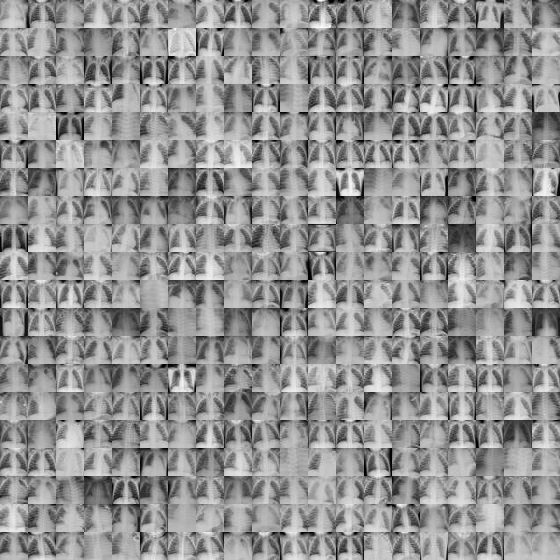

In [ ]:
train_dataset.montage(length=20)

In [ ]:
# Split samples in positive and negative ones, to plot them seperately and visually see the different characteristics of the classes
import numpy as np
import matplotlib.pyplot as pyplot

positive = []
negative = []
for i in range(100):
  el = train_dataset[i]
  if el[1] == 1:
    positive.append(el)
  else: 
    negative.append(el)


Plot postive samples (pneumonia): 


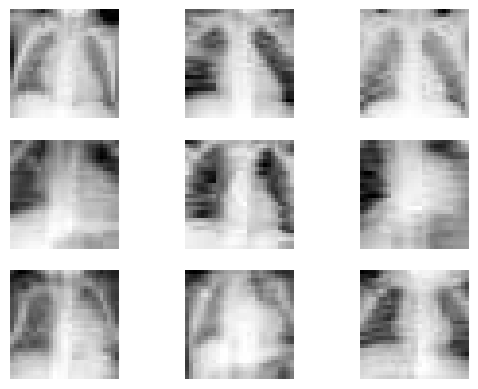

In [ ]:
print("Plot postive samples (pneumonia): ")
for i in range(9):
  # define subplot
  pyplot.subplot(3, 3, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  im = positive[i][0]
  imm = np.squeeze(im)
  pyplot.imshow(imm, cmap='gray')
pyplot.show()

Plot negative samples (healthy): 


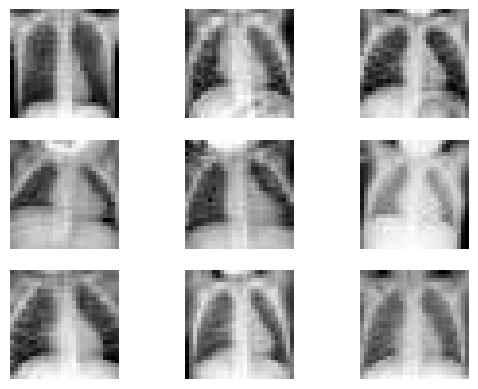

In [ ]:
print("Plot negative samples (healthy): ")
for i in range(9):
  # define subplot
  pyplot.subplot(3, 3, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  im = negative[i][0]
  imm = np.squeeze(im)
  pyplot.imshow(imm, cmap='gray')
pyplot.show()

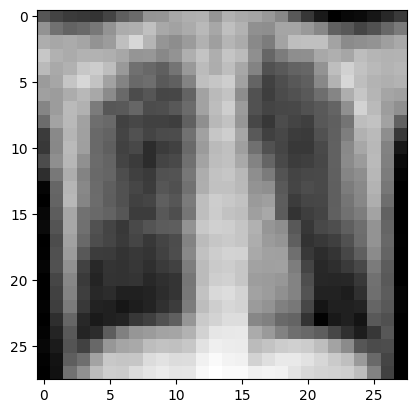

In [ ]:
# Inspect one sample on a larger scale. 
a = train_dataset[5][0].numpy()
pyplot.imshow(np.squeeze(a), interpolation='nearest', cmap="gray")

In [ ]:
def reshape(data):
  X = []
  y = []
  for el,ar in data:
    el_arr = el.numpy()
    X.append(el_arr)
    y.append(ar)
  X_arr = X[0]
  for i in range(len(X)):
    if i > 0: 
      newrow = X[i]
      X_arr = np.vstack([X_arr, newrow])
  y_arr = y[0]
  for i in range(len(y)):
    if i > 0:
      newrow = y[i]
      y_arr = np.vstack([y_arr, newrow])
  y_arr_sq = np.squeeze(y_arr)

  return X_arr, y_arr_sq

# Siamese Neural Network

In [ ]:
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, Dropout
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, shutil
from random import random, randint, seed
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from keras.utils.vis_utils import plot_model
from scipy import spatial
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

model = load_model(os.getcwd()+"/mse_encoder.h5")
siamese_model = load_model(os.getcwd()+"/mse_siamese_model.h5")



# Healthy Reference Computation

In [ ]:
# Computation of the healthy reference - Cluster centroid

realX, realy = reshape(train_dataset)
embeddings = model.predict(realX)
train = list(zip(embeddings, realy))
positives = [t for t in train if t[1] == 1]
positive_images = np.array([i[0] for i in positives])
positive_centroid = np.mean(positive_images, axis=0)
negatives = [t for t in train if t[1] == 0]
negative_images = np.array([i[0] for i in negatives])
negative_centroid = np.mean(negative_images, axis=0)

148/148 [==============================] - 2s 2ms/step


In [ ]:
def distance_prediction(centroid_healthy, centroid_sick, points): 
  distances = []
  for point in points: 
    dist_to_healthy = np.linalg.norm(point-centroid_healthy)
    dist_to_sick = np.linalg.norm(point-centroid_sick)
    res = (dist_to_healthy /  (dist_to_healthy + dist_to_sick))
    distances.append(res)
  return np.array(distances)

In [ ]:
def distance_prediction_cosine(centroid_healthy, centroid_sick, points): 
  distances = []
  for point in points: 
    p = point / np.linalg.norm(point)
    c = centroid_healthy / np.linalg.norm(centroid_healthy)
    d = np.dot(p,c)
    d = d + 1
    d = d / 2
    d = 1 - d
    distances.append(d)
  return np.array(distances)

In [ ]:
def distance_to_centroid(centroid, points):
  distances = []
  for point in points:
    dist = np.linalg.norm(point-centroid)
    distances.append(dist)
  return np.array(distances)


# LIME

lime_image.py select desired masking, mean, 0, 1 masking

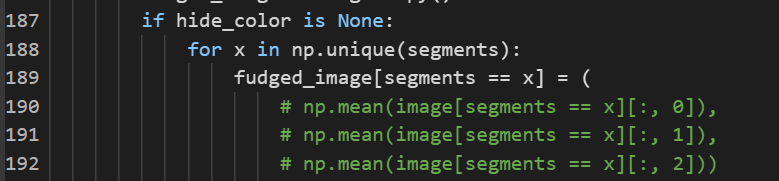

In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=55b2ab33c4bbe9896fc18697cd5a11755ea1cb3abeee6c345013fce91aebc67c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from keras.utils import to_categorical 
realX, realy = reshape(train_dataset)
testX, testy = reshape(test_dataset)

In [ ]:
from skimage.segmentation import mark_boundaries
%load_ext autoreload
%autoreload 2
import os,sys
from lime import lime_image
from skimage.segmentation import felzenszwalb, slic, quickshift, morphological_chan_vese
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer(kernel_width=0.25)


In [ ]:
def pred_lime(x, encoder, centroid_healthy, centroid_sick):
    x = x[:,:,:,0]
    res = []
    image_embedding = encoder.predict(x, verbose=0)
    for embed in image_embedding: 
      dist_healthy = np.linalg.norm(embed - centroid_healthy)
      res.append(np.array([dist_healthy]))

    # print(p)

    # print(res)
   
    return np.array(res)

def pred_ratio_lime(x, encoder, centroid_healthy, centroid_sick):
    x = x[:,:,:,0]
    res = []
    image_embedding = encoder.predict(x, verbose=0)
    for embed in image_embedding: 
      dist_healthy = np.linalg.norm(embed - centroid_healthy)
      dist_sick = np.linalg.norm(embed - centroid_sick)
      pred = dist_healthy / (dist_healthy + dist_sick)
      pred_health = pred
      pred_inverse = 1 - pred_health
      res.append(np.array([pred_health, pred_inverse]))
   
    return np.array(res)


def pred_ratio_lime_cosine(x, encoder, centroid_healthy, centroid_sick):
    x = x[:,:,:,0]
    res = []
    image_embedding = encoder.predict(x, verbose=0)
    for embed in image_embedding: 
      p = embed / np.linalg.norm(embed)
      c = centroid_healthy / np.linalg.norm(centroid_healthy)
      d = np.dot(p,c)
      d = d + 1
      d = d / 2
      i = 1 - d
      res.append(np.array([i, d]))
   
    return np.array(res)




def pred(x, encoder, centroid_healthy, centroid_sick):
    res = []
    image_embedding = encoder.predict(x)
    for embed in image_embedding: 
      dist_healthy = np.linalg.norm(embed - centroid_healthy)
      res.append(np.array([dist_healthy]))
   
    return np.array(res)

def pred_ratio(x, encoder, centroid_healthy, centroid_sick):
    res = []
    image_embedding = encoder.predict(x)
    for embed in image_embedding: 
      dist_healthy = np.linalg.norm(embed - centroid_healthy)
      dist_sick = np.linalg.norm(embed - centroid_sick)
      pred = dist_healthy / (dist_healthy + dist_sick)
      pred_health = 1 - pred
      pred_inverse = 1 - pred_health
      res.append(np.array([pred_health, pred_inverse]))
   
    return np.array(res)

def pred_instance(img, encoder, centroid_healthy, centroid_sick):
    image_embedding = encoder.predict(np.array([img,]))
    dist_healthy = np.linalg.norm(image_embedding - centroid_healthy)
    dist_sick = np.linalg.norm(image_embedding - centroid_sick)
    pred = dist_healthy / (dist_healthy + dist_sick)
    pred_health = 1 - pred
    pred_inverse = 1 - pred_health
   
    return np.array([pred_health, pred_inverse]) 

def pred_instance_classifier(img, encoder, classifier):
    image_embedding = encoder.predict(np.array([img,]))
    res = classifier.predict(image_embedding)
   
    return res

def generate_prediction_sample(exp, exp_class, weight = 0.0, show_positive = False, hide_background = True):
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=3, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

def visualize_Lime(image, explanation, truelabel, predictedlabel):
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[truelabel], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  
  f, axarr = plt.subplots(1,4, figsize=(20, 20))

  title = "Ground Truth: "

  if truelabel == 1.0: 
    title = title + "Pneumonie (1.0)"
  else: 
    title = title + "Healthy (0.0)"
  
  title = title + "   |   Prediction: " + str(predictedlabel)

  f.suptitle(title, y=0.62, fontsize=16)

  #Select the class that should be explained.
  ind =  explanation.top_labels[truelabel]

  #Map each explanation weight to the corresponding superpixel
  dict_heatmap = dict(explanation.local_exp[ind])
  heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
  axarr[0].set_title("Original Image") 
  axarr[0].imshow(image, interpolation='nearest', cmap="gray")
  axarr[1].set_title("Segmentation Result") 
  axarr[1].imshow(explanation.segments)
  axarr[2].set_title("Explanation Image") 
  axarr[2].imshow(temp / 2 + 0.5)
  axarr[3].set_title("Heatmap") 
  # print(heatmap.shape)
  im = axarr[3].imshow(heatmap, cmap = 'RdBu_r', vmin  = -heatmap.max(), vmax = heatmap.max())
  plt.colorbar(im,ax=axarr[3], fraction=0.046, pad=0.04)

In [ ]:
def explain_Lime(example, label, model, negative_centroid, positive_centroid, segmenter):
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  example = example.astype("double")
  ypred = pred_instance(example, model, negative_centroid, positive_centroid)
  explanation = explainer.explain_instance(example, classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter, batch_size=1, num_samples=200)
  visualize_Lime(example, explanation, label, ypred)

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

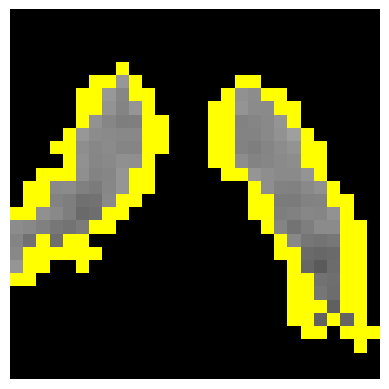

In [ ]:
segmenter = SegmentationAlgorithm(algo_type="quickshift",                                 
                                  kernel_size=1,
                                  max_dist=6)

i = 2
example = realX[i]
label = realy[i]
ypred = pred_instance(example, model, negative_centroid, positive_centroid)
explanation = explainer.explain_instance(example, classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter, batch_size=1, num_samples=200)
generate_prediction_sample(explanation, explanation.top_labels[1], show_positive = True, hide_background = True)

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

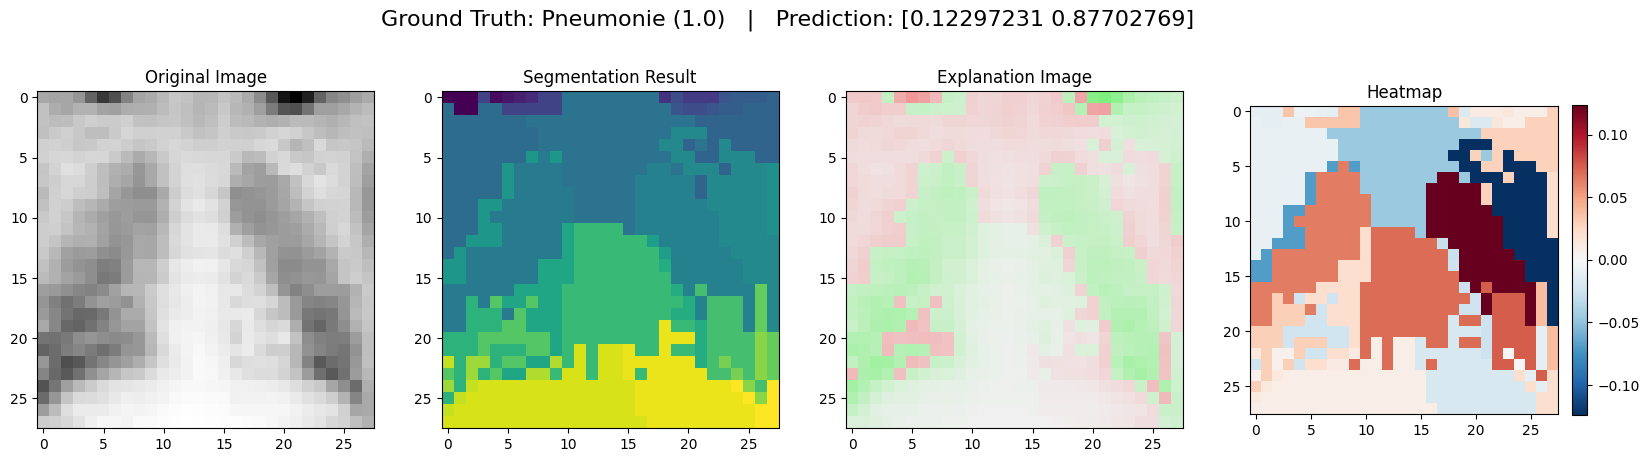

In [ ]:
# Mean masking
i = 2
example = realX[i]
label = realy[i]
explainer = lime_image.LimeImageExplainer()
explain_Lime(example, label, model, negative_centroid, positive_centroid, segmenter)

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

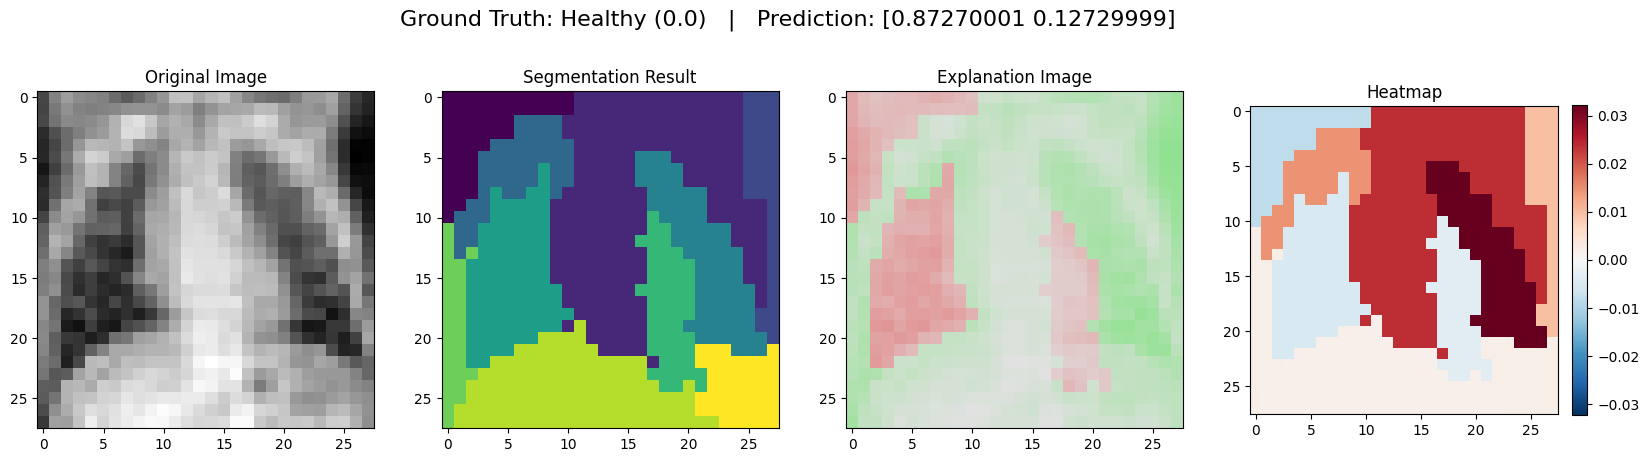

In [ ]:
#  Different Kernel sizes Felzenswalb
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter = SegmentationAlgorithm(algo_type="felzenszwalb",                                 
                                  scale=2.1,
                                  sigma=0.1,
                                  channel_axis=-1)
i = 7
example = realX[i]
label = realy[i]
explainer = lime_image.LimeImageExplainer()
explain_Lime(example, label, model, negative_centroid, positive_centroid, segmenter)

# RISE 

In [ ]:
from skimage.transform import resize
import numpy as np
import random
from skimage.filters import gaussian
from tqdm import tqdm
from numpy import newaxis

class RISE:
    
    """
    Generate heatmap explanations for image classifiers using the RISE methodology by Petsiuk et al. 
    (reference: https://arxiv.org/abs/1806.07421)
    Generate N binary masks of initial size s by s, which are then upsampled and applied to an image.
    Elements in the initial arrays are set to 1 with probability p1. Else, they are set to 0.
    The final heatmap is generated as a linear combination of the masks.
    The weights are obtained from the softmax probabilities predicted by the base model on the masked images
    """
    def __init__(self):
        
        self.model = None
        self.input_size = None
        self.masks = None
    
    def generate_masks(self,N, s, p1):

        """
        Generate a distribution of random binary masks.
        Args:
            N: Number of masks.
            s: Size of mask before upsampling.
            p1: Probability of setting element value to 1 in the initial mask.
            verbose: Verbose level for the model prediction step.
            batch_size: Batch size for predictions.
        Returns:
            masks: The distribution of upsampled masks.
        """

        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        # print("Grid shape: ", grid.shape)

        masks = np.empty((N, *self.input_size))

        # print("Mask Initialization shape: ", masks.shape)

        
        for i in range(N):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                    anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        masks = masks.reshape(-1, *self.input_size, 1)
        return masks    
        
    def explain(
        self, 
        inp, 
        model, 
        preprocessing_fn = None, 
        masks_user = None, 
        N = 2000, 
        s = 8, p1 = 
        0.5, 
        verbose = 0, 
        batch_size = 10, 
        mode = None,
        truelabel = 0,
    ):
        """
        Generate the explanation heatmaps for all classes.
        Args:
            model: The image classifier. Typically expects a Tensorflow 2.0/Keras model or equivalent class.
            inp: The image to be explained. Expected to be in the shape used by the model, without any color
            normalization or futher preprocessing applied. Ideally the any color preprocessing is included
            within the model class/function.
            preprocessing_fn: Not implemented yet. For now preprocessing should ideally be included within the model.
            masks_user: This function calls another function to generate a mask distribution. However a user generated
            distribution of masks can be passed with this argument.
            N: Number of masks.
            s: Size of mask before upsampling.
            p1: Probability of setting element value to 1 in the initial mask.
            verbose: Verbose level for the model prediction step.
            batch_size: Batch size for predictions.
            mode (experimental): Alternative perturbation modes instead of the simple black gradation mask. 'blur'
            is a Gaussian blur, 'noise' is colored noise and 'noise_bw' is black and white noise. If None will return
            the regular black gradation perturbations. Default is None. 
        Returns:
            sal: Explanation heatmaps for all classes. For a given class_id, the heatmap can be access 
            with sal[class_id].
            masks: The distribution of masks used for generating the set of heatmaps.
        """
        self.model = model
        self.input_size = model.input_shape[1:3]

        if masks_user == None: 
            self.masks = self.generate_masks(N, s, p1)
        else:
            self.masks = masks_user #In case the user wants to pass some custom numpy array of masks.
        
        # Make sure multiplication is being done for correct axes
        # print("masks shape: ", self.masks.shape)

        
        image = inp[:,:,newaxis]
        fudged_image = image.copy()

        if mode == 'blur': #Gaussian blur
            fudged_image = gaussian(fudged_image, sigma=4, multichannel=True, preserve_range = True)

        elif mode == 'noise': #Colored noise
            fudged_image = np.random.normal(255/2,255/9,size = fudged_image.shape).astype('int')

        elif mode == 'noise_bw': #Grayscale noise
            fudged_image = np.random.normal(255/2,255/5,size = (fudged_image.shape[:2])).astype('int')
            fudged_image = np.stack((fudged_image,)*3, axis=-1)
            
        else:
          if truelabel:
            fudged_image = np.ones(image.shape) #Regular perturbation with a black gradation
          else:
            fudged_image = np.zeros(image.shape)
        

        
        preds = []
        
        #Doing these matrix multiplications between the masks and the image can quickly eat up memory.
        #So we multiply the image with one batch of masks at a time and later append the predictions.
        # print("Model Input shape: ", model.input_shape)

        if(verbose):
            
            print('Using batch size: ',batch_size, flush = True)

        for i in (tqdm(range(0, N, batch_size)) if verbose else range(0, N, batch_size)):

            masks_batch = self.masks[i:min(i+batch_size, N)]
            masked = image*masks_batch + fudged_image*(1-masks_batch)
            # print("Image shape: ", image.shape)
            # print("Masked: ", masked.shape)
            # print(masked)

            
            to_append = model.predict(masked)

            # print("Append shape", to_append.shape)

            preds.append(to_append)

        preds = np.vstack(preds)

        # print("Prediction shape: ", preds.shape)

        # print("Dot shape: ", self.masks.reshape(N, -1).shape)


        sal = preds.T.dot(self.masks.reshape(N, -1)).reshape(-1, *self.input_size)

        # print("Heatmap shape: ", sal.shape)
        sal = sal / N / p1




        return sal, self.masks

In [ ]:
explainer = RISE()

In [ ]:
class RICEModel():

    def __init__(self,model, centroid_healthy, centroid_sick):
        self.model = model
        self.input_shape = (None, 28,28,1)
        self.output_shape = (1,)
        self.centroid_healthy = centroid_healthy
        self.centroid_sick = centroid_sick
        
    def predict(self, batch_images):
        res = []
        image_embedding = model.predict(batch_images, verbose=0)
        for embed in image_embedding: 
          dist_healthy = np.linalg.norm(embed - self.centroid_healthy)
          dist_sick = np.linalg.norm(embed - self.centroid_sick)
          pred = dist_healthy / (dist_healthy + dist_sick)
          pred_health = pred
          pred_inverse = 1 - pred_health
          res.append(np.array([pred_health, pred_inverse]))
      
        return np.array(res)


RICEmodel = RICEModel(model, negative_centroid, positive_centroid)

In [ ]:
def visualize_Rice(image, heatmaps, truelabel, predictedlabel):
  
  f, axarr = plt.subplots(1,3, figsize=(20, 20))

  title = "Ground Truth: "

  if truelabel == 1.0: 
    title = title + "Pneumonie (1.0)"
  else: 
    title = title + "Healthy (0.0)"
  
  title = title + "   |   Prediction: " + str(predictedlabel)

  f.suptitle(title, y=0.66, fontsize=16) 
  axarr[0].set_title("Original Image") 
  axarr[0].imshow(image, interpolation='nearest', cmap="gray")
  axarr[1].set_title("RICE Result for Healthy Class") 
  axarr[1].imshow(heatmaps[0],cmap='jet')
  axarr[1].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")
  axarr[2].set_title("RICE Result for Pneumonie Class") 
  axarr[2].imshow(heatmaps[1],cmap='jet')
  axarr[2].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")

def explain_Rice(example, label, model, negative_centroid, positive_centroid):
  explainer = RISE()
  ypred = pred_instance(example, model, negative_centroid, positive_centroid)
  RICEmodel = RICEModel(model, negative_centroid, positive_centroid)
  heatmaps, masks = explainer.explain(example,RICEmodel, truelabel = label)
  visualize_Rice(example, heatmaps, label, ypred)

1/1 [==============================] - 0s 18ms/step


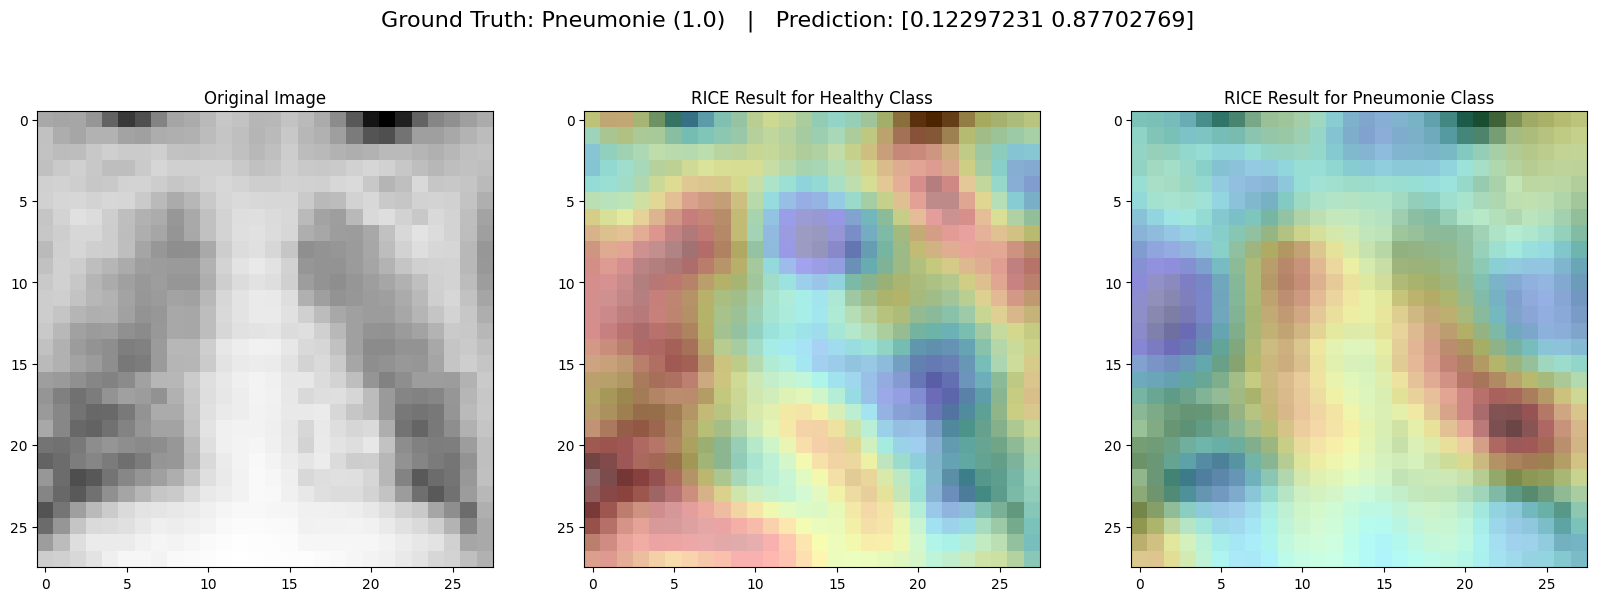

In [ ]:
i = 2
example = realX[i]
label = realy[i]
explain_Rice(example, label, model, negative_centroid, positive_centroid)

# Grad - Cam

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:

last_conv_layer_name = "conv2d_3"


In [ ]:
grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

In [ ]:
grad_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 784)               0     

In [ ]:
def get_img_array(img):
    array = np.expand_dims(img, axis=0)
    array = np.expand_dims(array, axis=3)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
example = realX[1]

1/1 [==============================] - 0s 70ms/step


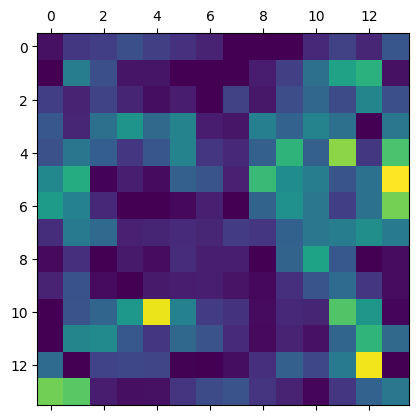

In [ ]:
# Prepare image
img_array = get_img_array(example)

preds = model.predict(img_array)

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

In [ ]:
def explain_GradCam(example, label, model, negative_centroid, positive_centroid):
  ypred = pred_instance(example, model, negative_centroid, positive_centroid)
  img_array = get_img_array(example)
  last_conv_layer_name = "conv2d_3"
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  visualize_GradCam(example, heatmap, label, ypred)


def visualize_GradCam(image, heatmap, truelabel, predictedlabel):
  
  f, axarr = plt.subplots(1,2, figsize=(20, 20))

  bigger_img = heatmap.repeat(2, axis=0).repeat(2, axis=1)


  title = "Ground Truth: "

  if truelabel == 1.0: 
    title = title + "Pneumonie (1.0)"
  else: 
    title = title + "Healthy (0.0)"
  
  title = title + "   |   Prediction: " + str(predictedlabel)

  f.suptitle(title, y=0.71, fontsize=16) 
  axarr[0].set_title("Original Image") 
  axarr[0].imshow(image, interpolation='nearest', cmap="gray")
  axarr[1].set_title("GradCam Result") 
  axarr[1].imshow(bigger_img,cmap='jet')
  axarr[1].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")


1/1 [==============================] - 0s 16ms/step


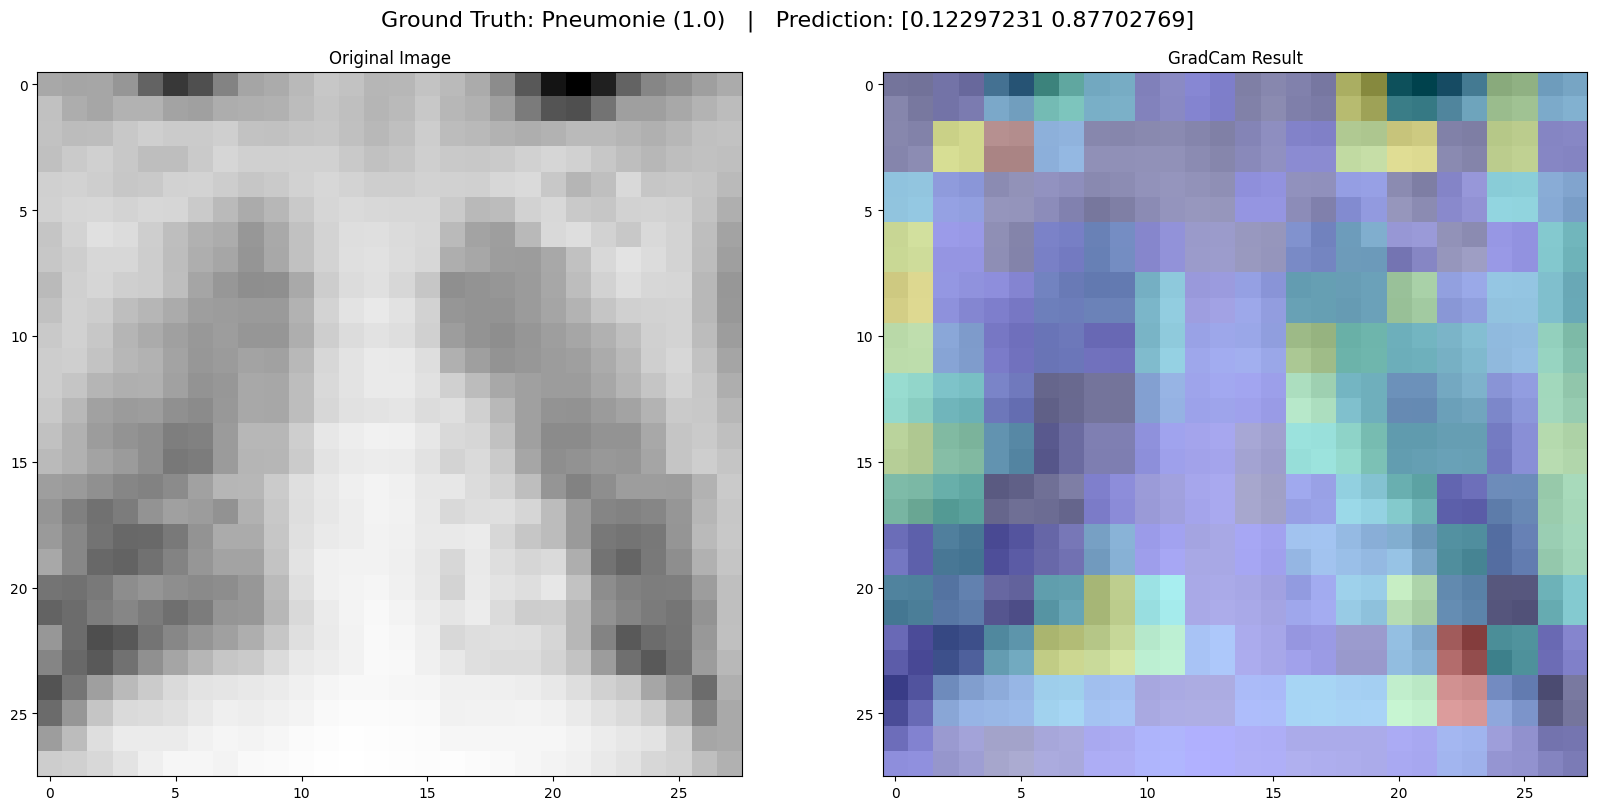

In [ ]:
i = 2
example = realX[i]
label = realy[i]
explain_GradCam(example, label, model, negative_centroid, positive_centroid)

# Visualization


In [ ]:
def visualize_comparison(image, explanation_Lime, heatmaps_Rice, heatmap_GradCam_1, heatmap_GradCam_2, truelabel, predictedlabel):

  f, axarr = plt.subplots(1,6, figsize=(30, 30))

  title = "Ground Truth: "

  if truelabel == 1.0: 
    title = title + "Pneumonie (1.0)"
  else: 
    title = title + "Healthy (0.0)"
  
  title = title + "   |   Prediction: " + str(predictedlabel)

  f.suptitle(title, y=0.59, fontsize=16)


  axarr[0].set_title("Original Image") 
  axarr[0].imshow(image, interpolation='nearest', cmap="gray")

  # Lime
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[truelabel], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  axarr[1].set_title("Explanation Image") 
  axarr[1].imshow(temp / 2 + 0.5)

  axarr[2].set_title("Heatmap")
  ind =  explanation_Lime.top_labels[truelabel]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  im = axarr[2].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[2], fraction=0.046, pad=0.04)

  # Rice

  axarr[3].set_title("RICE Result for Predicted Class") 
  axarr[3].imshow(heatmaps_Rice[truelabel],cmap='jet')
  axarr[3].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")

  # GradCam

  scaled_heatmap_gradcam_1 = heatmap_GradCam_1.repeat(2, axis=0).repeat(2, axis=1)
  axarr[4].set_title("GradCam Convolutional Layer 1") 
  axarr[4].imshow(scaled_heatmap_gradcam_1,cmap='jet')
  axarr[4].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")

  scaled_heatmap_gradcam_2 = heatmap_GradCam_2.repeat(2, axis=0).repeat(2, axis=1)
  axarr[5].set_title("GradCam Convolutional Layer 2") 
  axarr[5].imshow(scaled_heatmap_gradcam_2,cmap='jet')
  axarr[5].imshow(example, alpha=0.7, interpolation='nearest', cmap="gray")




def explain_comparison(example, label, model, negative_centroid, positive_centroid, segmenter):
  ypred = pred_instance(example, model, negative_centroid, positive_centroid)

  # Lime
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter, batch_size=1, num_samples=200)

  # Rice
  explainer = RISE()
  RICEmodel = RICEModel(model, negative_centroid, positive_centroid)
  heatmaps, masks = explainer.explain(example,RICEmodel, truelabel = label)
  # print(heatmaps[label].shape)

  # GradCam
  img_array = get_img_array(example)
  last_conv_layer_name = "conv2d_2"
  heatmap_1 = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  last_conv_layer_name = "conv2d_3"
  heatmap_2 = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Visualize
  visualize_comparison(example, explanation_lime, heatmaps, heatmap_1, heatmap_2, label, ypred)

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

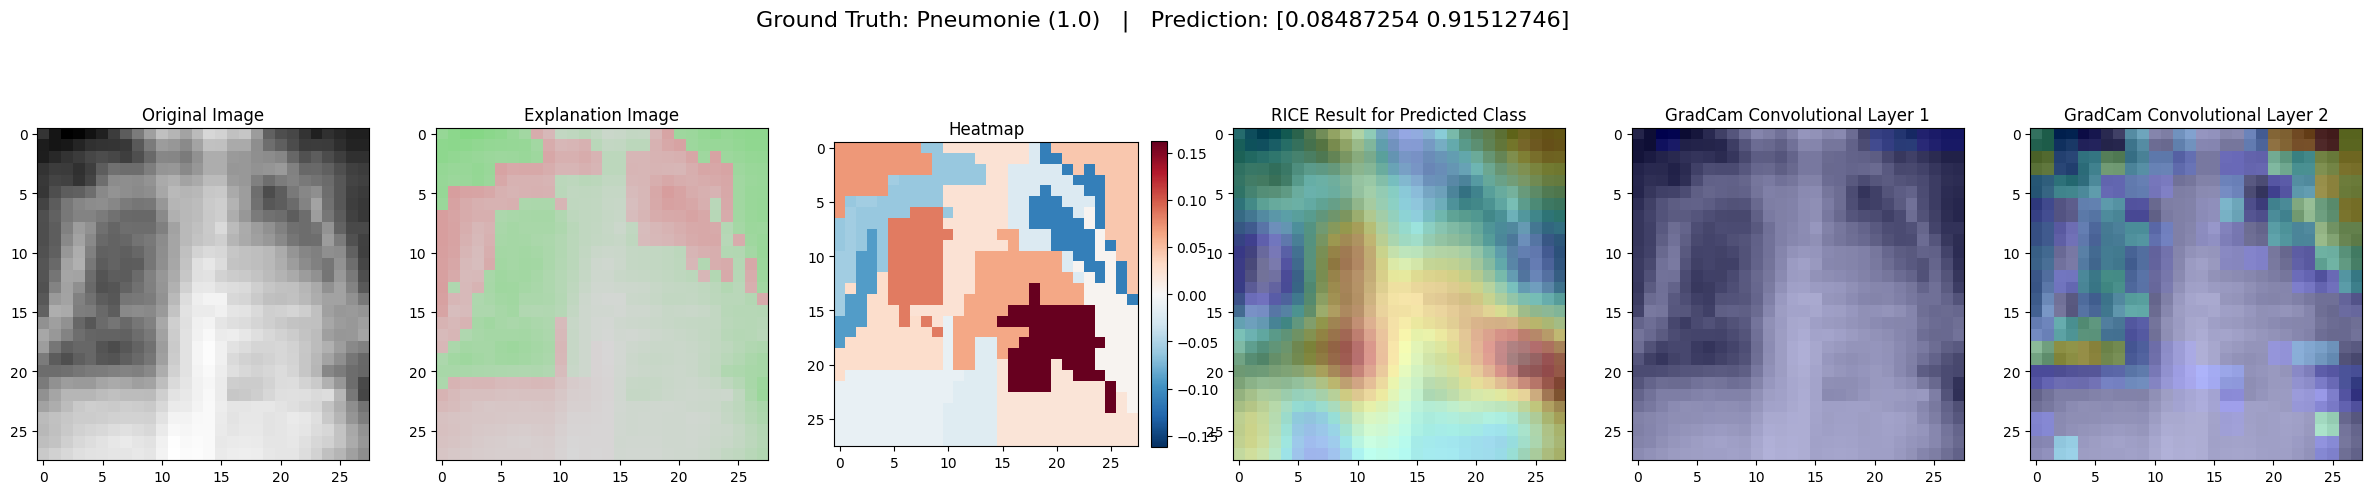

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter = SegmentationAlgorithm(algo_type="quickshift",                                 
                                  kernel_size=1,
                                  max_dist=16)

# 1 masking
i = 8
example = realX[i]
label = realy[i]
explain_comparison(example, label, model, negative_centroid, positive_centroid, segmenter)

# Explanation Overlap Cosine Similarity

In [ ]:
from numpy.linalg import norm

def compute_heatmaps(example, label, model, negative_centroid, positive_centroid, segmenter):
  ypred = pred_instance(example, model, negative_centroid, positive_centroid)

  # Lime
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter, batch_size=1, num_samples=1000)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  
  

  # Rice
  explainer = RISE()
  RICEmodel = RICEModel(model, negative_centroid, positive_centroid)
  heatmaps, masks = explainer.explain(example,RICEmodel, truelabel = label)
  heatmap_rice = heatmaps[label]
  heatmap_rice_flat = heatmap_rice.flatten()
  max_r = np.max(heatmap_rice_flat)
  min_r = np.min(heatmap_rice_flat)
  r_scaled = np.array([(x - min_r) / (max_r - min_r) for x in heatmap_rice_flat])

  # GradCam
  img_array = get_img_array(example)
  last_conv_layer_name = "conv2d_3"
  heatmap_2 = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  heatmap_gradcam = heatmap_2.repeat(2, axis=0).repeat(2, axis=1)
  heatmap_gradcam_flat = heatmap_gradcam.flatten()
  max_g = np.max(heatmap_gradcam_flat)
  min_g = np.min(heatmap_gradcam_flat)
  g_scaled = np.array([(x - min_g) / (max_g - min_g) for x in heatmap_gradcam_flat])

  return l_scaled, r_scaled, g_scaled


def visualize_cosine_overlap(image, segmeter1, segmenter2, segmenter3, segmenter4, segmenter5, truelabel, predictedlabel, negative_centroid, positive_centroid):

  f, axarr = plt.subplots(1,7, figsize=(40, 40))

  title = "Ground Truth: "

  if truelabel == 1.0: 
    title = title + "Pneumonie (1.0)"
  else: 
    title = title + "Healthy (0.0)"
  
  title = title + "   |   Prediction: " + str(predictedlabel)

  f.suptitle(title, y=0.59, fontsize=16)


  axarr[0].set_title("Original Image") 
  axarr[0].imshow(image, interpolation='nearest', cmap="gray")

   # Rice
  explainer = RISE()
  RICEmodel = RICEModel(model, negative_centroid, positive_centroid)
  heatmaps, masks = explainer.explain(image,RICEmodel, truelabel = truelabel)
  heatmap_rice = heatmaps[truelabel]
  heatmap_rice_flat = heatmap_rice.flatten()
  max_r = np.max(heatmap_rice_flat)
  min_r = np.min(heatmap_rice_flat)
  r_scaled = np.array([(x - min_r) / (max_r - min_r) for x in heatmap_rice_flat])
  # r_scaled[r_scaled < 0.65] = 0

  axarr[6].set_title("RICE Result for Predicted Class") 
  axarr[6].imshow(heatmap_rice,cmap='jet')
  axarr[6].imshow(image, alpha=0.7, interpolation='nearest', cmap="gray")

  # Lime Segmenter1
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter1, batch_size=1, num_samples=100)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  # l_scaled[l_scaled < 0.65] = 0

  c1 = np.dot(l_scaled,r_scaled)/(norm(l_scaled)*norm(r_scaled))

  axarr[1].set_title(c1) 
  im = axarr[1].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[1], fraction=0.046, pad=0.04)

   # Lime Segmenter2
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter2, batch_size=1, num_samples=100)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  # l_scaled[l_scaled < 0.65] = 0

  c1 = np.dot(l_scaled,r_scaled)/(norm(l_scaled)*norm(r_scaled))

  axarr[2].set_title(c1) 
  im = axarr[2].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[2], fraction=0.046, pad=0.04)

   # Lime Segmenter3
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter3, batch_size=1, num_samples=100)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  # l_scaled[l_scaled < 0.65] = 0

  c1 = np.dot(l_scaled,r_scaled)/(norm(l_scaled)*norm(r_scaled))

  axarr[3].set_title(c1) 
  im = axarr[3].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[3], fraction=0.046, pad=0.04)

    # Lime Segmenter4
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter4, batch_size=1, num_samples=100)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  # l_scaled[l_scaled < 0.65] = 0

  c1 = np.dot(l_scaled,r_scaled)/(norm(l_scaled)*norm(r_scaled))

  axarr[4].set_title(c1) 
  im = axarr[4].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[4], fraction=0.046, pad=0.04)

     # Lime Segmenter5
  explainer = lime_image.LimeImageExplainer(kernel_width=0.25)
  explanation_Lime = explainer.explain_instance(example.astype("double"), classifier_fn=lambda x: pred_ratio_lime(x, model, negative_centroid, positive_centroid), hide_color=None, segmentation_fn=segmenter5, batch_size=1, num_samples=100)
  temp, mask = explanation_Lime.get_image_and_mask(explanation_Lime.top_labels[label], positive_only=False, num_features=100, hide_rest=False, min_weight=0.0)
  ind =  explanation_Lime.top_labels[label]
  dict_heatmap = dict(explanation_Lime.local_exp[ind])
  heatmap_lime = np.vectorize(dict_heatmap.get)(explanation_Lime.segments)
  heatmap_lime_flat = heatmap_lime.flatten()

  max_l = np.max(heatmap_lime_flat)
  min_l = np.min(heatmap_lime_flat)
  l_scaled = np.array([(x - min_l) / (max_l - min_l) for x in heatmap_lime_flat])
  # l_scaled[l_scaled < 0.65] = 0

  c1 = np.dot(l_scaled,r_scaled)/(norm(l_scaled)*norm(r_scaled))

  axarr[5].set_title(c1) 
  im = axarr[5].imshow(heatmap_lime, cmap = 'RdBu_r', vmin  = -heatmap_lime.max(), vmax = heatmap_lime.max())
  plt.colorbar(im,ax=axarr[5], fraction=0.046, pad=0.04)







def compute_cosine_similarity_overlap(l,r,g):
  c1 = np.dot(l,r)/(norm(l)*norm(r))
  c2 = np.dot(l,g)/(norm(l) * norm(g))
  c3 = np.dot(g,r)/(norm(g) * norm(r))
  c = (c1 + c2 + c3) / 3
  return c



1/1 [==============================] - 0s 21ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

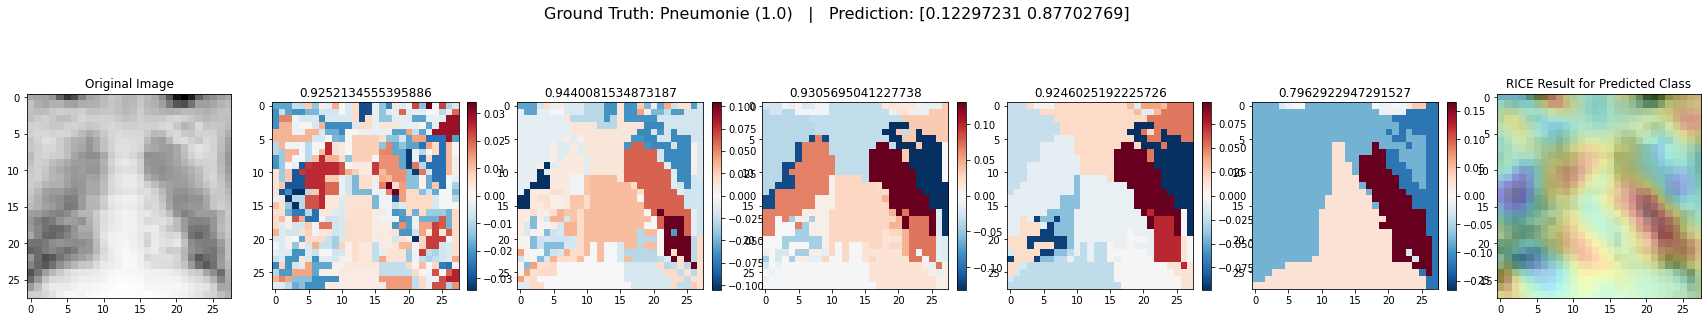

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter1 = SegmentationAlgorithm(algo_type="quickshift", kernel_size=1, max_dist=2)
segmenter2 = SegmentationAlgorithm(algo_type="quickshift", kernel_size=1, max_dist=4)
segmenter3= SegmentationAlgorithm(algo_type="quickshift", kernel_size=1, max_dist=6)
segmenter4 = SegmentationAlgorithm(algo_type="quickshift", kernel_size=4, max_dist=3)
segmenter5 = SegmentationAlgorithm(algo_type="quickshift", kernel_size=6, max_dist=5)

# Mean masking
i = 2
example = realX[i]
label = realy[i]
ypred = pred_instance(example, model, negative_centroid, positive_centroid)
visualize_cosine_overlap(example, segmenter1, segmenter2, segmenter3, segmenter4, segmenter5, label, ypred, negative_centroid, positive_centroid)

In [ ]:
c1 = np.dot(l,r)/(norm(l)*norm(r))
c1

0.9478141236467276

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmenter = SegmentationAlgorithm(algo_type="quickshift",                                 
                                  kernel_size=1,
                                  max_dist=3)
# Mean masking
i = 8
example = realX[i]
label = realy[i]
l,r,g = compute_heatmaps(example, label, model, negative_centroid, positive_centroid, segmenter)


c1 = np.dot(l,r)/(norm(l)*norm(r))
c1
# compute_cosine_similarity_overlap(l,r,g)

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

0.9304322525476102